# HW 3
### Unsupervised Learning
#### Gian Zlupko

First, I import the wine data to get started.

In [1]:
import pandas as pd
import os

# change working directory 
os.chdir('/Users/gianzlupko/Desktop/GR5073 ML/gr5073_ML/data')

# read in the red and white wine data sets
red_wine = pd.read_csv("winequality-red.csv", sep = ';') 

# inspect the data 
red_wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Next, I scale the data as data should be standardzied prior to using cluster analysis and PCA. 

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler() 
scaler.fit(red_wine)
wine_scaled = pd.DataFrame(scaler.transform(red_wine), columns = red_wine.columns) # retains col names for later use 

#### 1. Use K Means Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality.

#### If you want to make a good bottle of wine, then what characteristics are most important according to this analysis

To determine an appropriate value for `k` clusters using k-means, I use the elbow curve method below. The elbow curve method plots the differences in within-group sum of squares (WGSS) for each cluster and the elbow in the curve is a heuristic used to identify a value of `k` clusters that substantially reduces WGSS. 

Text(0.5, 1.0, 'Elbow curve')

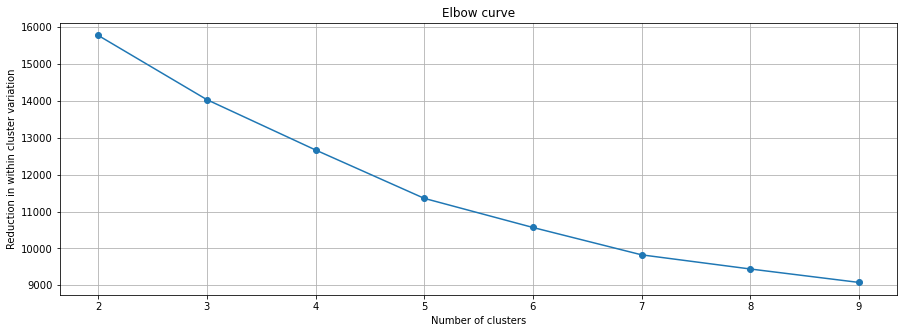

In [6]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') # disabling warnings for this code chunk 

within_cluster_variance = [] # initiate empty list with no data

# build models for range of ks from 2 to 20
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(wine_scaled)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve')  #Choose k at elbow of plot as a general rule.  We want a small enough number of categories to 
                          # such that we can still learn something meaningful from them via exploration of our variables.

While the curve method does not reveal a strong elbow in the plot, it appears that 7 clusters substantially reduces WSS with diminishing retunrs thereafter. Thus, I will use k = 7 clusters for k-means on the red wine data. Next, I fit the k-means model and I also visually inspect a sample plot of the clusters colored by group to examine their dispersion (specifically on the first two features below). 

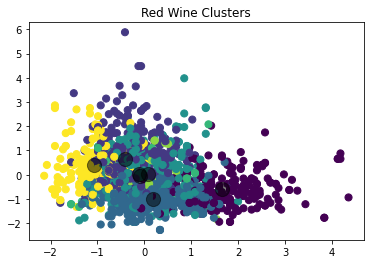

In [7]:
# fit k-means to the data
kmeans1 = KMeans(n_clusters = 7, random_state = 42)
kmeans1.fit(wine_scaled)
y_kmeans = kmeans1.predict(wine_scaled)

#plot data colored by k-means clusters from model
plt.scatter(wine_scaled.iloc[:, 0], wine_scaled.iloc[:, 1], c = y_kmeans, s=50, cmap='viridis')
plt.title("Red Wine Clusters")
centers = kmeans1.cluster_centers_ # extract final centroids from each cluster
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


The scatter plot shows the cloud of data points associated with each of the clusters as well as the centroids of each cluster in 2-dimensional space. The visual is not very useful in examining the differences between these sub-groups of the red wine data for the first two features. However, differences in quality by cluster may be more apparent. To assess which observations have high and low values of the wine quality, I first merge the cluster labels to the original data. 

In [8]:
wine_cluster = pd.DataFrame(wine_scaled)
wine_cluster['Cluster'] = kmeans1.labels_
wine_cluster['Cluster'] = wine_cluster.Cluster.astype('category')

# inspect new column with cluster labels 
wine_cluster.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Cluster
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,1
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823,1
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823,1
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848,0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,1


Next, I can visualize the differences in wine quality in a variety of ways. Below, I use a boxplot to examine which wine sub-groups are associated with higher or lower ratings of quality. 

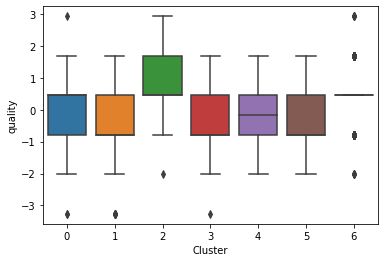

In [9]:
import seaborn as sns 
sns.boxplot(x = wine_cluster['Cluster'], y = wine_cluster['quality'])

The boxplot indicates that Cluster 3 has high values of quality (note: the third cluster is labeled 2, since python starts with 0). For more granularity, to see the other clusters that are associated with high or low wine quality, we can filter the data set by grouping each cluster and calculating each cluster's mean quality score. 

In [10]:
# calculate mean quality scores by cluster
wine_cluster.groupby(['Cluster'])['quality'].mean()


Cluster
0    0.156165
1   -0.521662
2    1.055668
3   -0.425017
4   -0.022761
5   -0.360695
6    0.468544
Name: quality, dtype: float64

We see that Cluster 7 (Python row 6) has the second highest quality score and cluster 2 (row 1) has the lowest quality wine score. Finally, to determine if the quality is significantly different across clusters, we can run a simple ANOVA. 

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# group by 
qual_data = wine_cluster[['Cluster', 'quality']] 
groups = qual_data.groupby('Cluster')
groups.head()

# Ordinary Least Squares (OLS) model
model = ols('quality ~ C(Cluster)', data= qual_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table) 


                 sum_sq      df           F         PR(>F)
C(Cluster)   534.003516     6.0  133.041691  1.142261e-136
Residual    1064.996484  1592.0         NaN            NaN


The ANOVA results indicate that there are statistically significant mean differences in wine quality across the clusters identified by k-means. 

Next, in addition to identifying clusters with high and low quality scores, this question also asks us to describe variables that cluster with higher and lower values of wine quality. To address this question, we can examine correlations between wine quality scores with the other features in the data set. 

In [12]:
# correlation matrix 
features_only = wine_cluster.drop(columns = ["Cluster"]) 
corr_matrix = features_only.corr() 

corr_matrix.style.background_gradient(cmap = 'coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


The results indicate that alcohol, citric acid, and sulphates are positively related to wine quality. Thus, better wines have greater levels of these characteristics according to correlational analysis. In contrast, poor wine quality in associated with density, total sulfur dioxide, and volatile acidity. Specifically, each of these characteristics of wine are inversely related to quality. This means that as the presence of each of these increases in wine, the quality of the wine decreases. Thus, lower quality wines are expected to contain greater levels of density, sulfur dioxide, and volatile acidity. Drawing on both of these findings, the results indicate that in order to make a good bottle of wine, producers should focus on low density and low sulfur wines, for example, while increasing the level of alcohol, citric acid and sulphates.

#### 2. Use Hierarchical Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Use complete linkage and the same number of groups that you found to be the most meaningful in question 1.

#### Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality.

First, using HCA, I examine a dendrogram to explore how HCA identifies sub-groups within the data set. 

In [13]:
hca_data = wine_scaled.drop("Cluster", axis = 1)

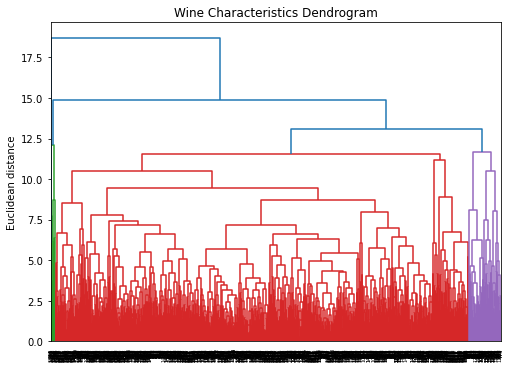

In [14]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

row_clusters = linkage(pdist(hca_data, metric='euclidean'), method='complete') 


from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

plt.figure(figsize=(7, 5))
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.title("Wine Characteristics Dendrogram")
plt.show()


Next, I fit the same number of clusters that I found most meaningful in Question 1 to the wine data using HCA with agglormerative clustering. 

Text(0.5, 1.0, 'Labeled Wine Data')

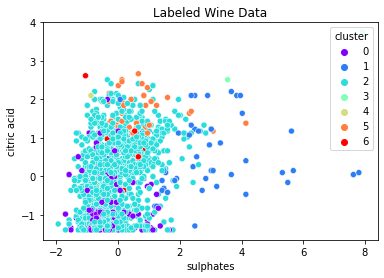

In [15]:

from sklearn.cluster import AgglomerativeClustering

# initialize the model 
cluster = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'complete')

# fit the HCA model 
cluster.fit_predict(hca_data)

# strore cluster labels into data set
hca_data["cluster"] = cluster.labels_

# plot the clusters along sample criteria 
sns.scatterplot(x = 'sulphates', 
y = 'citric acid', 
data = hca_data, 
hue = 'cluster', 
palette = 'rainbow').set_title('Labeled Wine Data')

It is difficult to determine where certain clusters fall along the two axes that are shown, citric acid and sulphate concentration, two variables that were previously shown to postively relate to high wine quality. For a more simple assessment of which clusters have the highest and lowest wine quality scores, we can calculate the average quality score for each cluster and examine each cluster's mean. We can also plot a box plot to examine the mean as well as IQR for quality score for each cluster. 

In [16]:
quality_clusters = hca_data[['cluster', 'quality']]

# calculate the mean
mean_quality = quality_clusters.groupby('cluster')['quality'].mean()
print(mean_quality)


cluster
0    0.165001
1   -0.335609
2   -0.027203
3   -1.407158
4    1.276629
5    0.669437
6    0.069719
Name: quality, dtype: float64


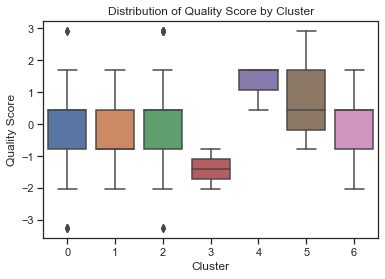

In [19]:
# subset the data to only include the quality and cluster columns
quality_clusters = hca_data[['quality', 'cluster']]

sns.set_theme(style = 'ticks')
# create a box plot of the quality score by cluster
sns.boxplot(x='cluster', y='quality', data=quality_clusters)

# set the title and axis labels
plt.title('Distribution of Quality Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quality Score')

# show the plot
plt.show()

Looking at the mean scores, we see that cluster 5 (python row 4) has the highest wine quality score and cluster 4 (row 3) has the lowest score. This result is also confirmed by the boxplot where we see that Cluster 5 has the high quality score, on average, and cluster 4 has the lowest quality score on average. 

Finally, to address the final components of Question 2 which asks us to desribe variables that cluster with high and low quality scores, respectively, we can examine the mean values for each feature in the high quality wine cluster as well as the mean values for each feature in the low quality wine scores. 

In [17]:
cluster_high_quality = hca_data[quality_clusters['cluster'] == mean_quality.idxmax()]
cluster_low_quality = hca_data[quality_clusters['cluster'] == mean_quality.idxmin()]

variables_high_quality = cluster_high_quality.mean().sort_values(ascending=False)[:3].index
variables_low_quality = cluster_low_quality.mean().sort_values(ascending=False)[:3].index

print("Variables that cluster with higher values of wine quality:", variables_high_quality)
print("Variables that cluster with lower values of wine quality:", variables_low_quality)


Variables that cluster with higher values of wine quality: Index(['total sulfur dioxide', 'residual sugar', 'cluster'], dtype='object')
Variables that cluster with lower values of wine quality: Index(['chlorides', 'sulphates', 'citric acid'], dtype='object')


The results suggest that the three variables that are most associated with high quality wine are total sulfur dioxide, residual sugar, and free sulfur dioxide. In the cluster with the highest quality wine scores, below are the average values for each of these variables. 

In [23]:
cluster_high_quality.mean().sort_values(ascending=False)[:4]

total sulfur dioxide    5.956069
residual sugar          5.293553
cluster                 4.000000
free sulfur dioxide     3.167777
dtype: float64

Finally, for the cluster with the lowest wine quality scores, we can examine the average values of the three variables that were most assoicated with this cluster. 

In [26]:
cluster_low_quality.mean().sort_values(ascending=False)[:3]

chlorides      11.116408
sulphates       5.735193
citric acid     3.127368
dtype: float64

According to the results obtained from hierarchical cluster analysis, if we want to make a good bottle of wine then the most important charactersitics are total sulfur dioxide, residual sugar, and free sulfur dioxide. These findings conflict with the results that I obtained above using k-means clustering. In particular, with k-means, I found that total sulfur dioxide was related to poor wine quality whereas using HCA the opposite was true. Additionally, using k-means, I found that citric acid was related to high quality wine. However, using HCA, the opposite was also true for citric acid. 

#### 3. Use Principal Components Analysis to reduce the dimensions of your data. How much of the variation in your data is explained by the first two principal components. 

First, I implement PCA on the originally scaled data without the cluster column.

In [31]:
# First, I get rid of the cluster column to return to the originally scaled data set 
wine_scaled = wine_scaled.drop('Cluster', axis=1)

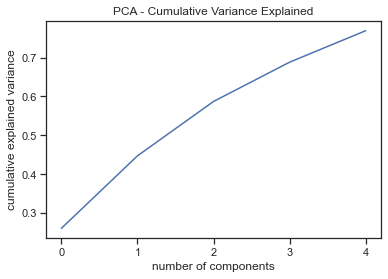

In [37]:
import numpy as np 
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
pca = PCA(n_components=5)
pca.fit_transform(wine_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("PCA - Cumulative Variance Explained")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))

By eyeballing the above plot, we can see that the first two principal components account for roughly 50% of the variance in the original data. For an exact number, we can use the following code. 

In [38]:
np.cumsum(pca.explained_variance_ratio_)

array([0.26009731, 0.44692081, 0.58716412, 0.68841586, 0.76952116])

The results indicate that the first two principal components account for 44.6% of the original variance in the data (that's 45% rounded). 

#### How might you use the first two components to do supervised learning on some other variable tied to wine (e.g. - wine price)?

The first two principal components could be extracted from the PCA results and used as input features in a supervised learning approach to predict a target variable like wine price. Specifically, after conducting PCA, the first two components and the target variable can be added to a data frame together*. Then, a standard supervised machine learning approach can be followed, including data splits and cross-fold validation if desired, in order to predict the outcome variable using the two components. The following example presents a demonstration for how PCA can be used upstream in supervised machine learning tasks. The target variable that I use in the demonstration is wine quality. 


*Note, the target variable should be left out of the PCA as the components are formed by linear combinations of the original variables and thus it would not make sense to predict a given variable that itself was part of the dimensionaltiy reduction task

In [59]:
# store the target variable, score 
y = wine_scaled[['quality']]

# run PCA without score 
demo_data = wine_scaled.drop('quality', axis = 1)
demo_pca = PCA(n_components=2)
pca_wine_char = demo_pca.fit_transform(wine_scaled)

#  store X data 
X = pd.DataFrame(data = pca_wine_char, columns = ['PC1', 'PC2'])
X.head(5) 


,PC1,PC2
0,-1.779442,1.157303
1,-1.004185,2.071838
2,-0.915783,1.393434
3,2.404077,-0.213792
4,-1.779442,1.157303


Next, we can a standard approach to supervised ML in python. 

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)  

# use a simple linear regression model 
from sklearn.linear_model import LinearRegression
model = LinearRegression() # instantiate 

# train the model 
model.fit(X_train, y_train) 

# Evaluate the model performance
from sklearn.metrics import r2_score 
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)


0.5206909039734177

The results show that the first two components account for 52% of the variance in the target variable, quality. 